## set correct pkl path below! 

In [12]:
# PASTE THE CORRECT PKL PATH HERE
PKL_PATH = "/Users/nikhil/Desktop/cc_hardware/cc-hardware/logs/2025-04-24/12-44-14/arrow_data.pkl"


In [15]:
import pickle
import numpy as np

def load_all_pickles(path):
    with open(path, "rb") as f:
        while True:
            try:
                yield pickle.load(f)
            except EOFError:
                break

def normalize_histograms(entries):
    normalized = []
    for entry in entries:
        hist = entry.get("histogram")
        if hist is not None and not isinstance(hist, np.ndarray):
            entry["histogram"] = np.array(hist)
        normalized.append(entry)
    return normalized


try:
    all_objs = list(load_all_pickles(PKL_PATH))
except FileNotFoundError:
    raise FileNotFoundError("PKL FILE PATH GIVEN DOESNT EXIST -- double check what path youve set above!")

top_info, *data_entries = all_objs

print("Top-level info:")
print(top_info)

num_captures = len(data_entries)
print(f"\nNumber of captures (entries): {num_captures}")

if data_entries:
    data_entries = normalize_histograms(data_entries)
    sample = data_entries[0]

    print("\nFirst sample entry:")
    print(sample)

    hist = sample.get("histogram")
    if hist is not None:
        print(f"Histogram shape: {hist.shape}")

    # ——— Machine‐Learning Dataset Preparation ———

    # We’re now building the core arrays for training a predictive model:
    #  • X (inputs): each row is a 1×m feature vector, where m is the number of histogram bins
    #                  (we’ve averaged out the n channels so that each capture becomes a single vector)
    #  • y (targets): each row is a length-2 vector [x, y] that gives the true position for that capture
    #
    # In supervised learning, we feed X and y into a training algorithm so it can learn
    # how to predict positions from histogram patterns. Once trained, the model takes a new
    # histogram (one row of X) and outputs its best estimate of [x, y].
    #
    hist_list = []
    pos_list = []
    for entry in data_entries:
        # average over channels (axis=0) → length-m vector
        avg_hist = entry["histogram"].mean(axis=0)
        hist_list.append(avg_hist)

        # collect the ground-truth position for this capture
        p = entry.get("pos", {})
        pos_list.append([p["x"], p["y"]])

    X = np.vstack(hist_list)   # shape: (num_captures, m)
    y = np.array(pos_list)     # shape: (num_captures, 2)

    # ——— Summary ———
    print("\nDataset prepared for machine learning:")
    print("  • X is your feature matrix (inputs), one row per capture,")
    print("    each row a length-m vector of averaged histogram counts.")
    print("  • y is your target matrix (ground truths), one row per capture,")
    print("    each row the [x, y] position you want the model to learn.")
    print(f"\nShapes: X → {X.shape}  (samples, features);  y → {y.shape}  (samples, 2-coord location)")
    print("\nNext steps: split X and y into training/testing sets,")
    print("then fit a regression or neural network model on (X_train, y_train),")
    print("and evaluate its accuracy on (X_test, y_test).")



Top-level info:
{'metadata': {'object': 'arrow', 'spad_position': {'x': 0.1, 'y': 0.4, 'z': 0.5}, 'start_time': '2025-04-24T12:44:14.065909'}}

Number of captures (entries): 4

First sample entry:
{'iter': 0, 'pos': {'x': 0.0, 'y': 0.0}, 'histogram': array([[1377, 1320, 1372, ..., 1257, 1327, 1251],
       [1165, 1167, 1175, ..., 1044, 1078, 1086],
       [1128, 1146, 1173, ..., 1062, 1052, 1085],
       ...,
       [1295, 1319, 1213, ..., 1246, 1191, 1248],
       [1023, 1070, 1012, ...,  964,  944,  896],
       [ 905,  884,  827, ...,  796,  810,  817]], dtype=int32)}
Histogram shape: (9, 128)

Dataset prepared for machine learning:
  • X is your feature matrix (inputs), one row per capture,
    each row a length-m vector of averaged histogram counts.
  • y is your target matrix (ground truths), one row per capture,
    each row the [x, y] position you want the model to learn.

Shapes: X → (4, 128)  (samples, features);  y → (4, 2)  (samples, 2-coord location)

Next steps: split X a

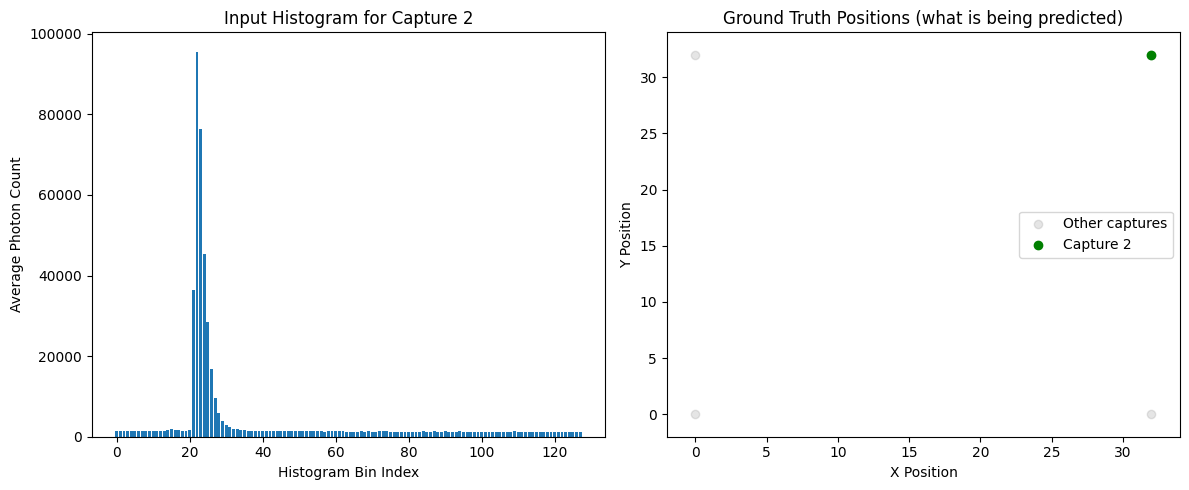

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# ——— Visualization of a single capture ———

# Set this to the capture index you want to inspect
INDEX = 2

# visualization funcs below 
hist = X[INDEX]          # 1×m feature vector for capture INDEX
pos = y[INDEX]           # [x, y] ground-truth for capture INDEX
x_all = y[:, 0]
y_all = y[:, 1]
buffer = 2
x_min, x_max = x_all.min() - buffer, x_all.max() + buffer
y_min, y_max = y_all.min() - buffer, y_all.max() + buffer

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: the INPUT feature histogram
ax1.bar(np.arange(hist.size), hist)
ax1.set_title(f"Input Histogram for Capture {INDEX}")
ax1.set_xlabel("Histogram Bin Index")
ax1.set_ylabel("Average Photon Count")

# Right: ground-truth positions
ax2.scatter(x_all, y_all, alpha=0.2, color="gray", label="Other captures")
ax2.scatter(pos[0], pos[1], color="green", label=f"Capture {INDEX}")
ax2.set_title("Ground Truth Positions (what is being predicted)")
ax2.set_xlabel("X Position")
ax2.set_ylabel("Y Position")
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.legend()

plt.tight_layout()
plt.show()


## Training a simple ML model

## Introduction and Problem Statement
In this tutorial, we’ll learn how to build a simple **supervised regression** model that predicts a 2D position (`x, y`) from an averaged photon‐count histogram.  
- **Inputs (`X`)**: an array of shape `(n_samples, n_features)`, where each row is an averaged histogram vector—your feature matrix.  
- **Outputs (`y`)**: an array of shape `(n_samples, 2)`, where each row is the true `[x, y]` position—your target values.  

We will cover each step in detail, explaining why we:
1. Split data into training/testing sets  
2. Choose and fit a model  
3. Measure its accuracy  
4. Visualize results  
5. Plan improvements  
By the end, you’ll understand the full workflow from raw data to basic model evaluation.


## Import Required Libraries
We need tools to:
- **Split** our data into training and test portions  
- **Fit** a regression algorithm  
- **Compute metrics** that quantify prediction error  
All of these are provided by the popular **scikit-learn** library.


In [29]:
! python -m pip install scikit-learn 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


## Splitting Data into Training and Testing Sets
Why split?  
- The **training set** (e.g. 80% of samples) teaches the model patterns in the data.  
- The **test set** (remaining 20%) assesses how well the model generalizes to new, unseen examples.  
Using `random_state=42` ensures you can reproduce the exact same split each time.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shapes:", X_train.shape, y_train.shape)
print("Testing  set shapes:",  X_test.shape,  y_test.shape)

Training set shapes: (3, 128) (3, 2)
Testing  set shapes: (1, 128) (1, 2)


## Initializing and Training a Regression Model
We’ll start with **Linear Regression**, which assumes a linear relationship between histogram features and positions.  
- **Initialize**: create the model object with default settings.  
- **Fit**: compute the best‐fit coefficients using the training data.

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)
print("Training complete: model has learned coefficients.")

Training complete: model has learned coefficients.


## Evaluating Model Performance on the Test Set
After training, we **predict** positions for `X_test` and compare to the true `y_test`.  
- **Mean Squared Error (MSE)**: average of squared prediction errors; lower is better.  
- **R² score**: fraction of variance in `y` explained by the model (1.0 = perfect, 0.0 = no better than the mean).


In [32]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}  → average squared distance between true and predicted positions")
print(f"R² score:              {r2:.2f}  → proportion of variance in y captured by the model")

Mean Squared Error (MSE): 279.60  → average squared distance between true and predicted positions
R² score:              nan  → proportion of variance in y captured by the model


/Users/nikhil/miniconda3/envs/cc_hardware/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


## Visualizing Predictions vs. True Values
Visual checks help reveal systematic errors:
- For each coordinate (`x` and `y`), we scatter **true** vs. **predicted** values.  
- A diagonal line shows where perfect predictions would lie.  
- Points off the line indicate over- or under-prediction.

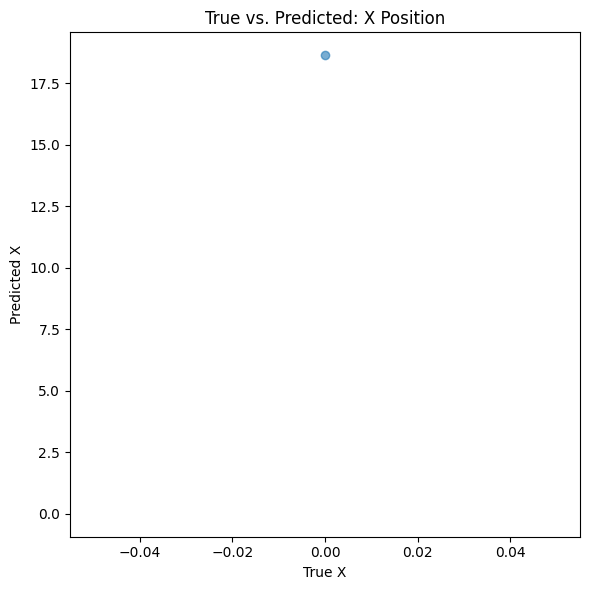

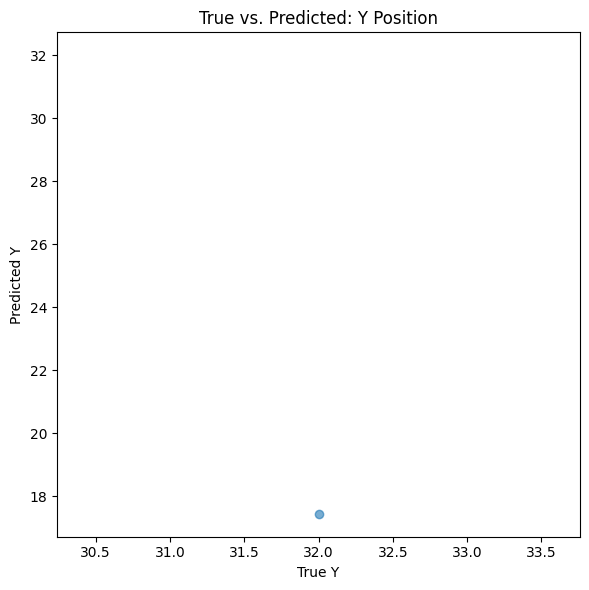

In [33]:
import matplotlib.pyplot as plt

# Plot for X coordinate
plt.figure(figsize=(6,6))
plt.scatter(y_test[:,0], y_pred[:,0], alpha=0.6)
plt.plot([y_test[:,0].min(), y_test[:,0].max()],
         [y_test[:,0].min(), y_test[:,0].max()],
         'k--', lw=2)
plt.title("True vs. Predicted: X Position")
plt.xlabel("True X")
plt.ylabel("Predicted X")
plt.tight_layout()
plt.show()

# Plot for Y coordinate
plt.figure(figsize=(6,6))
plt.scatter(y_test[:,1], y_pred[:,1], alpha=0.6)
plt.plot([y_test[:,1].min(), y_test[:,1].max()],
         [y_test[:,1].min(), y_test[:,1].max()],
         'k--', lw=2)
plt.title("True vs. Predicted: Y Position")
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.tight_layout()
plt.show()